**Import Dependencies**

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

**Load Data**

In [6]:
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

In [7]:
movies.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
ratings.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


**Exploratory Data Analysis**

In [9]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100836
Number of unique movieId's: 9724
Number of unique users: 610
Average number of ratings per user: 165.3
Average number of ratings per movie: 10.37


### Distribution of movie ratings

<ipython-input-10-fd10740cabcd>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating',data = ratings, palette="pastel")


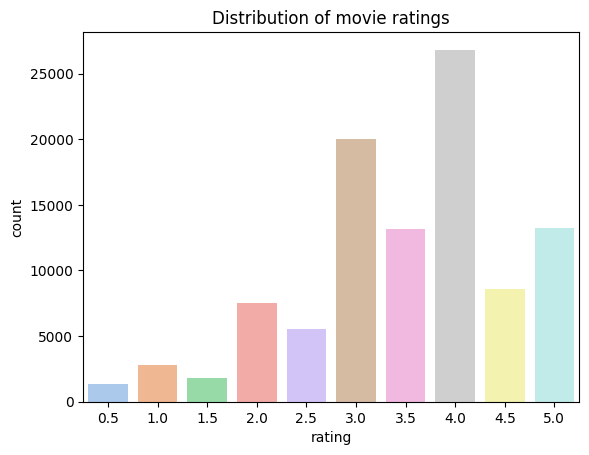

In [10]:
sns.countplot(x='rating',data = ratings, palette="pastel")
plt.title("Distribution of movie ratings")
plt.show()

In [11]:
print(f"Mean global rating: {round(ratings['rating'].mean(),2)}.")

mean_ratings = ratings.groupby('userId')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}.")

Mean global rating: 3.5.
Mean rating per user: 3.66.


### Which movies are most frequently played?

In [12]:
movie_ratings = ratings.merge(movies, on='movieId')
movie_ratings['title'].value_counts()[0:10]


,count
title,
Forrest Gump (1994),329
"Shawshank Redemption, The (1994)",317
Pulp Fiction (1994),307
"Silence of the Lambs, The (1991)",279
"Matrix, The (1999)",278
Star Wars: Episode IV - A New Hope (1977),251
Jurassic Park (1993),238
Braveheart (1995),237
Terminator 2: Judgment Day (1991),224


In [13]:
movie_ratings.head(5)

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


### Least Rated and Most Rated movies.

In [14]:
# least rated
print("Least Rated Movie:")
mean_ratings = ratings.groupby('movieId')[['rating']].mean()
lowest_rated = mean_ratings['rating'].idxmin()
movies[movies['movieId'] == lowest_rated]

Least Rated Movie:


,movieId,title,genres
2689,3604,Gypsy (1962),Musical


In [15]:
print("Highest rated Movie: ")
highest_rated = mean_ratings['rating'].idxmax()
movies[movies['movieId'] == highest_rated]

Highest rated Movie: 


,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


In [16]:
no_of_ratings_for_highest_rated = ratings[ratings['movieId']==highest_rated]
print("Number of ratings for highest rated movie: ")
print(no_of_ratings_for_highest_rated['rating'])
no_of_ratings_for_highest_rated['rating'].count()


Number of ratings for highest rated movie: 
13368    5.0
96115    5.0
Name: rating, dtype: float64


2

- here if we observe it averaging the ratings irrespective of total no of ratings. hence we need to do bayesian average :
bayesian_average.svg


where C represents our confidence, m represents our prior, and n is the total number of reviews for movie i. In this case, our prior m will be the average mean rating of average ratings across all movies. By defintion, C represents "the typical data set size". Let's make C be the average number of ratings for a given movie.

In [17]:
movie_stats = ratings.groupby('movieId')['rating'].agg(['count', 'mean'])
movie_stats.head()

,count,mean
movieId,,
1,215,3.920930
2,110,3.431818
3,52,3.259615
4,7,2.357143
5,49,3.071429


In [18]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()
print(f"Average number of ratings for a given movie: {C:.2f}")
print(f"Average rating for a given movie: {m:.2f}")
def bayesian_avg(ratings):
    bayesian_avg = (C*m + ratings.sum())/(C + ratings.count())
    return bayesian_avg

Average number of ratings for a given movie: 10.37
Average rating for a given movie: 3.26


In [19]:
print(f"Weighted Average of lamerica: {bayesian_avg(pd.Series([5,5]))}")

Weighted Average of lamerica: 3.5433826131392228


In [63]:
bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId','bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')
movie_stats.head()

,movieId,count,mean,bayesian_avg_x,title,bayesian_avg_y
0,1,215,3.920930,3.890632,Toy Story (1995),3.890632
1,2,110,3.431818,3.417227,Jumanji (1995),3.417227
2,3,52,3.259615,3.260086,Grumpier Old Men (1995),3.260086
3,4,7,2.357143,2.897612,Waiting to Exhale (1995),2.897612
4,5,49,3.071429,3.104793,Father of the Bride Part II (1995),3.104793


In [21]:
movie_stats = movie_stats.merge(movies[['movieId', 'title']])
movie_stats.sort_values('bayesian_avg', ascending=False).head()

,movieId,count,mean,bayesian_avg,title
277,318,317,4.429022,4.392070,"Shawshank Redemption, The (1994)"
659,858,192,4.289062,4.236457,"Godfather, The (1972)"
2224,2959,218,4.272936,4.227052,Fight Club (1999)
224,260,251,4.231076,4.192646,Star Wars: Episode IV - A New Hope (1977)
46,50,204,4.237745,4.190567,"Usual Suspects, The (1995)"


Using the Bayesian average, we see that Shawshank Redemption, The Godfather, and The Usual Suspects are the most highly rated movies. This result makes much more sense since these movies are critically acclaimed films.


In [22]:
movie_stats.sort_values('bayesian_avg', ascending=True).head()

,movieId,count,mean,bayesian_avg,title
1172,1556,19,1.605263,2.190377,Speed 2: Cruise Control (1997)
2679,3593,19,1.657895,2.224426,Battlefield Earth (2000)
1372,1882,33,1.954545,2.267268,Godzilla (1998)
1144,1499,27,1.925926,2.296800,Anaconda (1997)
1988,2643,16,1.687500,2.306841,Superman IV: The Quest for Peace (1987)


With Bayesian averaging, it looks like Speed 2: Cruise Control, Battlefield Earth, and Godzilla are the worst rated movies. Gypsy isn't so bad after all.

### Lets Look into genre

In [23]:
movies['genres'] = movies['genres'].apply(lambda x: x.split("|"))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]



  - genres is expressed as a string with a pipe | separating each genre. We will manipulate this string into a list, which will make it much easier to analyze.
  - title currently has (year) appended at the end. We will extract year from each title string and create a new column for it.


In [24]:
from collections import Counter
genre_frequency = Counter(g for genres in movies['genres'] for g in genres)
print(f"There are {len(genre_frequency)} genres.")

genre_frequency

There are 20 genres.


Counter({'Adventure': 1263,
         'Animation': 611,
         'Children': 664,
         'Comedy': 3756,
         'Fantasy': 779,
         'Romance': 1596,
         'Drama': 4361,
         'Action': 1828,
         'Crime': 1199,
         'Thriller': 1894,
         'Horror': 978,
         'Mystery': 573,
         'Sci-Fi': 980,
         'War': 382,
         'Musical': 334,
         'Documentary': 440,
         'IMAX': 158,
         'Western': 167,
         'Film-Noir': 87,
         '(no genres listed)': 34})

In [25]:
print("The 5 most common genres: \n", genre_frequency.most_common(5))

The 5 most common genres: 
 [('Drama', 4361), ('Comedy', 3756), ('Thriller', 1894), ('Action', 1828), ('Romance', 1596)]


In [26]:
genre_frequency_df = pd.DataFrame([genre_frequency]).T.reset_index()
genre_frequency_df.columns = ['genre', 'count']

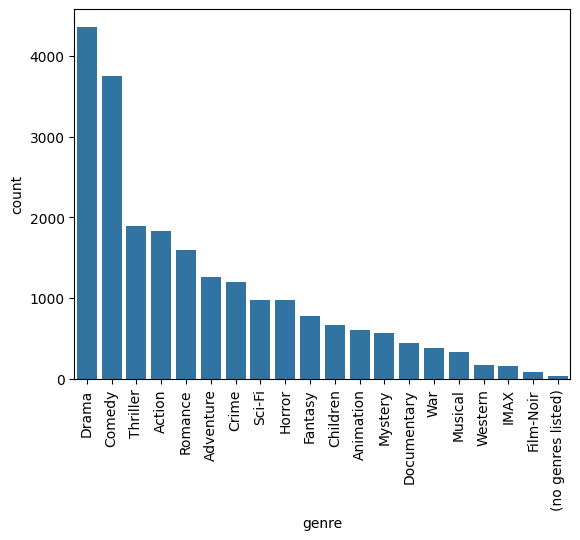

In [27]:
sns.barplot(x='genre', y='count', data=genre_frequency_df.sort_values(by='count', ascending=False))
plt.xticks(rotation=90)
plt.show()


### Data PreProcessing
To generate recommendations, we will use a technique called collaborative filtering. This method is based on the principle that users with similar preferences are likely to enjoy similar items.

The initial step involves transforming our data into a user-item matrix, also referred to as a "utility matrix." In this matrix:

    Rows represent users.
    Columns represent movies.

One of the key advantages of collaborative filtering is that it relies solely on user-item interactions, making it independent of additional information about the users or the movies.

The create_utility() function outputs a sparse matrix

with four mapper dictionaries:

    user_mapper: maps user id to user index
    movie_mapper: maps movie id to movie index
    user_inv_mapper: maps user index to user id
    movie_inv_mapper: maps movie index to movie id

We need these dictionaries because they map which row/column of the utility matrix corresponds to which user/movie id.

In [28]:
from scipy.sparse import csr_matrix

def create_utility(df):
  M = df['userId'].nunique()
  N = df['movieId'].nunique()

  user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
  movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))
  user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
  movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))
  user_index = [user_mapper[i] for i in df['userId']]
  movie_index = [movie_mapper[i] for i in df['movieId']]
  X = csr_matrix((df["rating"], (user_index, movie_index)), shape=(M, N))
  return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_utility(ratings)


In [76]:
# Print the shape of the training and test matrices
print(f"Training matrix shape: {X_train.shape}")
print(f"Test matrix shape: {X_test.shape}")

Training matrix shape: (610, 8983)
Test matrix shape: (610, 5142)


In [29]:
X.shape

(610, 9724)

### Evaluating sparsity

In [30]:
n_total = X.shape[0]*X.shape[1]
n_ratings = X.nnz
sparsity = n_ratings/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 1.7%


The cold start problem is when there are new users and movies in our matrix that do not have any ratings. In our Movielens dataset, all users and movies have at least one rating but in general, it's useful to check which users and movies have few interactions.

In [31]:
n_ratings_per_user = X.getnnz(axis=1)
len(n_ratings_per_user)

610

In [32]:
print(f"Most active user rated {n_ratings_per_user.max()} movies.")
print(f"Least active user rated {n_ratings_per_user.min()} movies.")

Most active user rated 2698 movies.
Least active user rated 20 movies.


In [33]:
n_ratings_per_movie = X.getnnz(axis=0)
len(n_ratings_per_movie)


9724

In [34]:
print(f"Most rated movie has {n_ratings_per_movie.max()} ratings.")
print(f"Least rated movie has {n_ratings_per_movie.min()} ratings.")

Most rated movie has 329 ratings.
Least rated movie has 1 ratings.


<ipython-input-35-44089890dcd7>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(n_ratings_per_user, shade=True)
<ipython-input-35-44089890dcd7>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(n_ratings_per_movie, shade=True)


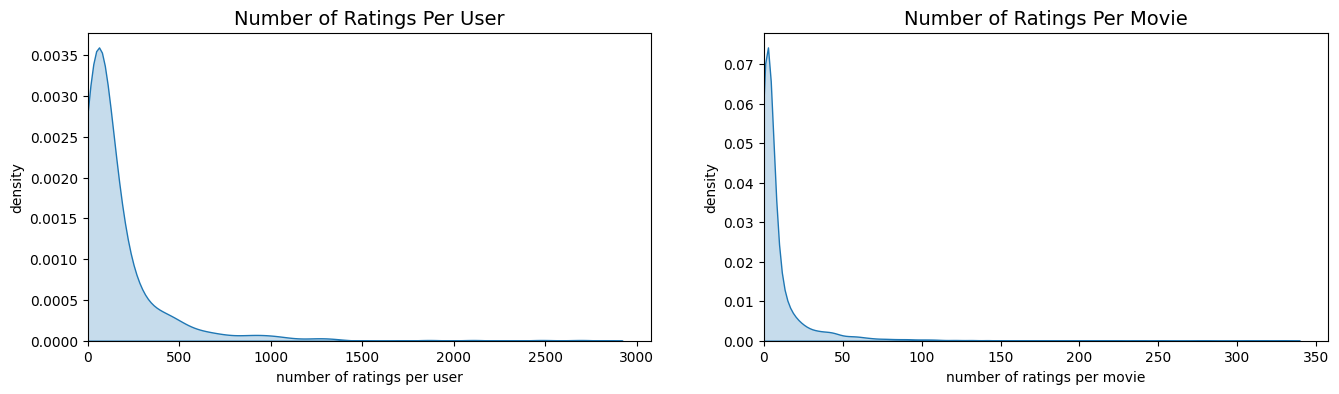

In [35]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(n_ratings_per_user, shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per User", fontsize=14)
plt.xlabel("number of ratings per user")
plt.ylabel("density")
plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_movie, shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per Movie", fontsize=14)
plt.xlabel("number of ratings per movie")
plt.ylabel("density")
plt.show()

### Item-Item Recommendation with k-Nearest Neighbors
We are going to find the k movies that have the most similar user engagement vectors for movie i.

In [36]:
from sklearn.neighbors import NearestNeighbors
def find_similar_movies(movie_id, X, movie_mapper,movie_inv_mapper,k, metric='cosine'):
  X = X.T
  neighbour_ids = []
  movie_ind = movie_mapper[movie_id]
  movie_vec = X[movie_ind]
  if isinstance(movie_vec, (np.ndarray)):
    movie_vec = movie_vec.reshape(1,-1)
  print(movie_vec.shape)
  knn = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
  knn.fit(X)
  neighbour = knn.kneighbors(movie_vec,return_distance = False)
  for i in range(0,k):
    n = neighbour.item(i)
    neighbour_ids.append(movie_inv_mapper[n])
  neighbour_ids.pop(0)
  return neighbour_ids

find_similar_movies() takes in a movieId and X matrix, and outputs a list of

movies that are similar to the movieId of interest.

Let's see how it works in action. We will first create another mapper that maps movieId to title so that our results are interpretable.

In [37]:
similar_movies = find_similar_movies(1, X, movie_mapper, movie_inv_mapper, k=10)
similar_movies

(1, 610)


[3114, 480, 780, 260, 356, 364, 1210, 648, 1265]

find_similar_movies() returns a list of movieId's that are most similar to your movie of interest. Let's convert these id's to titles so that we can interpret our results. To make things easier, we will create a dictionary that maps movieId to title.

### Performance check
Split Data into Train and Test Sets

In [85]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)

Create Utility Matrix for Training and Testing


In [86]:
# Create utility matrix for training data
X_train, user_mapper_train, movie_mapper_train, user_inv_mapper_train, movie_inv_mapper_train = create_utility(train_data)

# Create utility matrix for testing data
X_test, user_mapper_test, movie_mapper_test, user_inv_mapper_test, movie_inv_mapper_test = create_utility(test_data)

Evaluate Accuracy Before Matrix Factorization

In [91]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Function to predict ratings using kNN
def predict_ratings_knn(X_train, X_test, user_mapper, movie_mapper, k=10, metric='cosine'):
    predicted_ratings = []
    actual_ratings = []

    for user_id, movie_id, rating in test_data[['userId', 'movieId', 'rating']].values:
        if user_id in user_mapper and movie_id in movie_mapper:
            user_index = user_mapper[user_id]
            movie_index = movie_mapper[movie_id]
            similar_movies = find_similar_movies(movie_id, X_train, movie_mapper_train, movie_inv_mapper_train, k=k, metric=metric)

            # Predict rating as the average rating of similar movies by the same user
            similar_ratings = [X_train[user_index, movie_mapper_train[m]] for m in similar_movies if X_train[user_index, movie_mapper_train[m]] != 0]
            if similar_ratings:
                predicted_rating = np.mean(similar_ratings)
            else:
                predicted_rating = 0  # Default prediction if no similar ratings are found

            predicted_ratings.append(predicted_rating)
            actual_ratings.append(rating)

    return predicted_ratings, actual_ratings

# Predict ratings using kNN
predicted_ratings_knn, actual_ratings_knn = predict_ratings_knn(X_train, X_test, user_mapper_train, movie_mapper_train)

# Calculate RMSE
rmse_knn = sqrt(mean_squared_error(actual_ratings_knn, predicted_ratings_knn))
print(f"RMSE before matrix factorization (kNN): {rmse_knn:.4f}")

Streaming output truncated to the last 5000 lines.
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 

In [90]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Function to predict ratings using kNN
def predict_ratings_knn(X, user_mapper, movie_mapper, data, k=10, metric='cosine'):
    predicted_ratings = []
    actual_ratings = []

    for user_id, movie_id, rating in data[['userId', 'movieId', 'rating']].values:
        if user_id in user_mapper and movie_id in movie_mapper:
            user_index = user_mapper[user_id]
            movie_index = movie_mapper[movie_id]
            similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k=k, metric=metric)

            # Predict rating as the average rating of similar movies by the same user
            similar_ratings = [X[user_index, movie_mapper[m]] for m in similar_movies if m in movie_mapper and X[user_index, movie_mapper[m]] != 0]
            if similar_ratings:
                predicted_rating = np.mean(similar_ratings)
            else:
                predicted_rating = 0  # Default prediction if no similar ratings are found

            predicted_ratings.append(predicted_rating)
            actual_ratings.append(rating)

    return predicted_ratings, actual_ratings

# Function to evaluate overfitting by comparing RMSE for training and test data
def evaluate_overfitting(X_train, X_test, user_mapper_train, movie_mapper_train, user_mapper_test, movie_mapper_test, train_data, test_data, k=10, metric='cosine'):
    # Predict ratings for training data
    predicted_ratings_train, actual_ratings_train = predict_ratings_knn(X_train, user_mapper_train, movie_mapper_train, train_data, k=k, metric=metric)

    # Calculate RMSE for training data
    rmse_train = sqrt(mean_squared_error(actual_ratings_train, predicted_ratings_train))
    print(f"Train RMSE: {rmse_train:.4f}")

    # Predict ratings for testing data
    predicted_ratings_test, actual_ratings_test = predict_ratings_knn(X_test, user_mapper_test, movie_mapper_test, test_data, k=k, metric=metric)

    # Calculate RMSE for testing data
    rmse_test = sqrt(mean_squared_error(actual_ratings_test, predicted_ratings_test))
    print(f"Test RMSE: {rmse_test:.4f}")

    # Compare RMSE values to check for overfitting
    if rmse_train < rmse_test:
        print("Model might be overfitting!")
    else:
        print("Model performance is consistent across training and test data.")

# Evaluate the model and check for overfitting
evaluate_overfitting(X_train, X_test, user_mapper_train, movie_mapper_train, user_mapper_test, movie_mapper_test, train_data, test_data, k=10, metric='cosine')


Streaming output truncated to the last 5000 lines.
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 610)
(1, 

In [41]:
movie_titles = dict(zip(movies['movieId'],movies['title']))

movie_id = 1

similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k=10)
movie_title = movie_titles[movie_id]

print(f"Since you watched {movie_title}")
for i in similar_movies:
  print(movie_titles[i])

(1, 610)
Since you watched Toy Story (1995)
Toy Story 2 (1999)
Jurassic Park (1993)
Independence Day (a.k.a. ID4) (1996)
Star Wars: Episode IV - A New Hope (1977)
Forrest Gump (1994)
Lion King, The (1994)
Star Wars: Episode VI - Return of the Jedi (1983)
Mission: Impossible (1996)
Groundhog Day (1993)




The results above show the 10 movies that are most similar to Toy Story. Most movies in this list are family movies from the 1990s, which seems pretty reasonable. Note that these recommendations are based solely on user-item ratings. Movie features such as genres are not used in this approach.

You can also play around with the kNN distance metric and see what results you would get if you use "manhattan" or "euclidean" instead of "cosine".


In [42]:
movie_id = 1

similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, metric='euclidean', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])


(1, 610)
Because you watched Toy Story (1995):
Toy Story 2 (1999)
Mission: Impossible (1996)
Independence Day (a.k.a. ID4) (1996)
Bug's Life, A (1998)
Nutty Professor, The (1996)
Willy Wonka & the Chocolate Factory (1971)
Babe (1995)
Groundhog Day (1993)
Mask, The (1994)


### Handling the cold-start problem

Collaborative filtering depends entirely on user-item interactions within the utility matrix. However, this approach faces a challenge known as the cold start problem, where new users or items with no prior interactions cannot be included in the recommendation system. To address this, we can use content-based filtering, which generates recommendations based on the features of users and items.

As a first step, we need to transform the genres column into binary features. Each genre will be represented as a separate column in the dataframe, with values of 0 or 1 indicating the absence or presence of that genre, respectively.

In [43]:
n_movies = movies['movieId'].nunique()
print(f"There are {n_movies} unique movies in our movies dataset.")

There are 9742 unique movies in our movies dataset.


In [44]:
genres = set(g for G in movies['genres'] for g in G)

for g in genres:
    movies[g] = movies.genres.transform(lambda x: int(g in x))

movie_genres = movies.drop(columns=['movieId', 'title','genres'])

In [45]:
movie_genres.head()

,Western,IMAX,Animation,Drama,Musical,(no genres listed),Romance,Crime,Sci-Fi,Thriller,Film-Noir,Comedy,Fantasy,Documentary,War,Children,Horror,Adventure,Mystery,Action
0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0
2,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [46]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(movie_genres, movie_genres)
print(f"Dimensions of our genres cosine similarity matrix: {cosine_sim.shape}")

Dimensions of our genres cosine similarity matrix: (9742, 9742)


As expected, after passing the movie_genres dataframe into the cosine_similarity() function, we obtain a cosine similarity matrix with a shape of (n-movies, n-movies).

This matrix contains values between 0 and 1, which represent the degree of similarity between movies along both the x and y axes.

### Creating a movie finder function

Let’s say we want to get movie recommendations similar to Jumanji. To retrieve results from our recommender, we need to know the exact title of a movie in our dataset.

In our dataset, Jumanji is listed as 'Jumanji (1995)', so if we misspell the title or forget to include its release year, our recommender won’t be able to identify the correct movie.

To improve the user experience, we can use a Python package called fuzzywuzzy, which finds the most similar title to a string you pass in. Let’s create a function called movie_finder(), which leverages fuzzywuzzy’s string matching algorithm to return the most similar title based on a user-inputted string.

In [47]:
pip install fuzzywuzzy

In [48]:
pip install python-Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.7/162.7 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 28.0 MB/s eta 0:00:00


In [49]:
from fuzzywuzzy import process

def movie_finder(title):
    all_titles = movies['title'].tolist()
    closest_match = process.extractOne(title,all_titles)
    return closest_match[0]

In [50]:
title = movie_finder('jumaji')
title

'Jumanji (1995)'



To get relevant recommendations for Jumanji, we need to find its index in the cosine simialrity matrix. To identify which row we should be looking at, we can create a movie index mapper which maps a movie title to the index that it represents in our matrix.

Let's create a movie index dictionary called movie_idx where the keys are movie titles and values are movie indices:


In [51]:
movie_idx = dict(zip(movies['title'], list(movies.index)))
idx = movie_idx[title]
print(f"Movie index for Jumanji: {idx}")

Movie index for Jumanji: 1


Using this handy movie_idx dictionary, we know that Jumanji is represented by index 1 in our matrix. Let's get the top 10 most similar movies to Jumanji.

In [52]:
n_recommendations=10
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(n_recommendations+1)]
similar_movies = [i[0] for i in sim_scores]

In [53]:
print(f"Because you watched {title}:")
movies['title'].iloc[similar_movies]


Because you watched Jumanji (1995):


,title
53,"Indian in the Cupboard, The (1995)"
109,"NeverEnding Story III, The (1994)"
767,Escape to Witch Mountain (1975)
1514,Darby O'Gill and the Little People (1959)
1556,Return to Oz (1985)
1617,"NeverEnding Story, The (1984)"
1618,"NeverEnding Story II: The Next Chapter, The (1..."
1799,Santa Claus: The Movie (1985)
3574,Harry Potter and the Sorcerer's Stone (a.k.a. ...
6075,"Chronicles of Narnia: The Lion, the Witch and ..."


Great! Now, to make it easier for users to test the recommender with various movie titles and customize the number of recommendations, we can package everything into a single function. This function will take in the movie title of interest and the number of recommendations as input and return the relevant movie recommendations.

In [54]:
def get_content_based_recommendations(title_string, n_recommendations=10):
    title = movie_finder(title_string)
    idx = movie_idx[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(n_recommendations+1)]
    similar_movies = [i[0] for i in sim_scores]
    print(f"Because you watched {title}:")
    print(movies['title'].iloc[similar_movies])

In [55]:
get_content_based_recommendations('toy story', 30)

Because you watched Toy Story (1995):
1706                                          Antz (1998)
2355                                   Toy Story 2 (1999)
2809       Adventures of Rocky and Bullwinkle, The (2000)
3000                     Emperor's New Groove, The (2000)
3568                                Monsters, Inc. (2001)
6194                                     Wild, The (2006)
6486                               Shrek the Third (2007)
6948                       Tale of Despereaux, The (2008)
7760    Asterix and the Vikings (Astérix et les Viking...
8219                                         Turbo (2013)
8927                             The Good Dinosaur (2015)
9430                                         Moana (2016)
559                                      Space Jam (1996)
3194                                         Shrek (2001)
5490    Twelve Tasks of Asterix, The (Les douze travau...
5977                                       Valiant (2005)
6260                              

### Advanced Dimensionality Reduction with Matrix Factorization
Matrix factorization (MF) is a powerful linear algebra technique used to uncover hidden patterns in user-item interactions, such as between users and movies. By identifying latent features, MF provides a more compact and insightful representation of user preferences and movie characteristics. This method is especially beneficial for handling sparse data and can significantly improve the quality of recommendation systems.

The core idea behind matrix factorization is to decompose the original user-item interaction matrix into two smaller matrices:

    User-factor matrix: of dimensions nusers×knusers​×k, where each row represents a user’s preferences across kk latent features.
    Item-factor matrix: of dimensions k×nitemsk×nitems​, where each column represents a movie’s characteristics across the same kk latent features.

Through this process, we reduce the dimensionality of the original matrix into "taste" dimensions. While we cannot explicitly interpret each latent feature, we can imagine that one latent factor might correspond to users who prefer romantic comedies from the 1990s, while another factor could represent movies in independent foreign languages.

The matrix factorization model approximates the original user-item matrix XX as the product of the two smaller matrices PP and QQ:
Xmn≈Pmk×QnkT=X^
Xmn​≈Pmk​×QnkT​=X^

Here:

    XmnXmn​ is the original rating for user mm and movie nn.
    X^mnX^mn​ is the predicted rating.
    PmkPmk​ represents the user's preference for the kk-th latent feature.
    QnkQnk​ represents the item's profile for the kk-th latent feature.

This factorization allows us to make predictions for missing ratings and generate more personalized recommendations.

$$ X_{mn} \approx P_{mk} \times Q_{nk}^T = \hat{X} $$


In [56]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=20,n_iter=10)
Q = svd.fit_transform(X.T)
Q.shape

(9724, 20)

In [57]:
movie_id = 1
similar_movies = find_similar_movies(movie_id, Q.T, movie_mapper, movie_inv_mapper, metric='cosine', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

(1, 20)
Because you watched Toy Story (1995):
Home Alone (1990)
Jurassic Park (1993)
Aladdin (1992)
Willy Wonka & the Chocolate Factory (1971)
Back to the Future (1985)
Forrest Gump (1994)
Groundhog Day (1993)
Star Wars: Episode IV - A New Hope (1977)
Princess Bride, The (1987)


In [73]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
from math import sqrt

# Assuming X_train is your training utility matrix (user-item matrix)
n_components = 5  # Number of latent features
svd = TruncatedSVD(n_components=n_components, n_iter=10, random_state=42)

# Perform matrix factorization
Q_train = svd.fit_transform(X_train.T)  # Movie-factor matrix (shape: N x k)
P_train = svd.components_.T  # User-factor matrix (shape: M x k)

# Reconstruct the utility matrix
X_train_reconstructed = P_train @ Q_train.T  # Shape should be M x N (user-item matrix)

# For prediction
predicted_ratings_mf = []
actual_ratings_mf = []

# Assuming test_data is a DataFrame with columns: userId, movieId, rating
for user_id, movie_id, rating in test_data[['userId', 'movieId', 'rating']].values:
    if user_id in user_mapper_train and movie_id in movie_mapper_train:
        user_index = user_mapper_train[user_id]
        movie_index = movie_mapper_train[movie_id]
        predicted_rating = X_train_reconstructed[user_index, movie_index]
        predicted_ratings_mf.append(predicted_rating)
        actual_ratings_mf.append(rating)

# Calculate RMSE
rmse_mf = sqrt(mean_squared_error(actual_ratings_mf, predicted_ratings_mf))
print(f"RMSE after matrix factorization (SVD): {rmse_mf:.4f}")


RMSE after matrix factorization (SVD): 2.9468


The results above are the most similar movies to Toy Story using kNN on our “compressed” movie-factor matrix. We reduced the dimensions down to n_components=20. We can think of each component representing a latent feature such as movie genre.

In [92]:
# Compute RMSE on the training set

predicted_ratings_train = []
actual_ratings_train = []

for user_id, movie_id, rating in train_data[['userId', 'movieId', 'rating']].values:
    if user_id in user_mapper_train and movie_id in movie_mapper_train:
        user_index = user_mapper_train[user_id]
        movie_index = movie_mapper_train[movie_id]
        predicted_rating = X_train_reconstructed[user_index, movie_index]
        predicted_ratings_train.append(predicted_rating)
        actual_ratings_train.append(rating)

rmse_train = sqrt(mean_squared_error(actual_ratings_train, predicted_ratings_train))
print(f"RMSE on training set: {rmse_train:.4f}")

# RMSE on test set is already calculated earlier as rmse_mf
print(f"RMSE on test set (SVD): {rmse_mf:.4f}")


RMSE on training set: 2.8443
RMSE on test set (SVD): 2.9468


In [59]:
pip install implicit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 58.3 MB/s eta 0:00:00


In [70]:
from implicit.als import AlternatingLeastSquares
from scipy.sparse import csr_matrix

# Convert the utility matrix to COO format (required by implicit)
X_train_coo = X_train.tocoo()

# Train ALS model
als_model = AlternatingLeastSquares(
     factors=10,          # Increase the number of latent features
    regularization=0.1,   # Increase regularization
    iterations=50,        # Increase the number of iterations
    alpha=40,             # Confidence weighting for implicit feedback
    random_state=42       # Random seed for reproducibility
)
als_model.fit(X_train_coo)

# Get user and movie factors
user_factors = als_model.user_factors
movie_factors = als_model.item_factors

# Reconstruct the utility matrix
X_train_reconstructed = user_factors @ movie_factors.T

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0017135143280029297 seconds
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

In [71]:
# Predict ratings for the test set
predicted_ratings_mf = []
actual_ratings_mf = []

for user_id, movie_id, rating in test_data[['userId', 'movieId', 'rating']].values:
    if user_id in user_mapper_train and movie_id in movie_mapper_train:
        user_index = user_mapper_train[user_id]
        movie_index = movie_mapper_train[movie_id]
        predicted_rating = X_train_reconstructed[user_index, movie_index]
    else:
        # Fallback for cold start (use global mean rating)
        predicted_rating = 3.5

    predicted_ratings_mf.append(predicted_rating)
    actual_ratings_mf.append(rating)

In [72]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Calculate RMSE for ALS
rmse_mf = sqrt(mean_squared_error(actual_ratings_mf, predicted_ratings_mf))
print(f"RMSE after matrix factorization (ALS): {rmse_mf:.4f}")

RMSE after matrix factorization (ALS): 2.8194


In [97]:
# prompt: generate code to evaluate als model overfitting or not

# Function to evaluate overfitting by comparing RMSE for training and test data
def evaluate_overfitting_als(als_model, user_factors, movie_factors, user_mapper_train, movie_mapper_train, train_data, test_data):
    # Predict ratings for training data
    predicted_ratings_train, actual_ratings_train = predict_ratings_als(als_model, user_factors, movie_factors, user_mapper_train, movie_mapper_train, train_data)

    # Calculate RMSE for training data
    rmse_train = sqrt(mean_squared_error(actual_ratings_train, predicted_ratings_train))
    print(f"Train RMSE (ALS): {rmse_train:.4f}")

    # Predict ratings for testing data
    predicted_ratings_test, actual_ratings_test = predict_ratings_als(als_model, user_factors, movie_factors, user_mapper_train, movie_mapper_train, test_data)

    # Calculate RMSE for testing data
    rmse_test = sqrt(mean_squared_error(actual_ratings_test, predicted_ratings_test))
    print(f"Test RMSE (ALS): {rmse_test:.4f}")

    # Compare RMSE values to check for overfitting
    if rmse_train < rmse_test:
        print("ALS Model might be overfitting!")
    else:
        print("ALS Model performance is consistent across training and test data.")

def predict_ratings_als(als_model, user_factors, movie_factors, user_mapper_train, movie_mapper_train, data):
    predicted_ratings = []
    actual_ratings = []
    for user_id, movie_id, rating in data[['userId', 'movieId', 'rating']].values:
        if user_id in user_mapper_train and movie_id in movie_mapper_train:
            user_index = user_mapper_train[user_id]
            movie_index = movie_mapper_train[movie_id]
            predicted_rating = user_factors[user_index, :] @ movie_factors[movie_index, :].T
            predicted_ratings.append(predicted_rating)
            actual_ratings.append(rating)
        else:
            predicted_ratings.append(3.5) # Use a default value for cold start
            actual_ratings.append(rating)
    return predicted_ratings, actual_ratings

# Evaluate the ALS model and check for overfitting
evaluate_overfitting_als(als_model, user_factors, movie_factors, user_mapper_train, movie_mapper_train, train_data, test_data)


Train RMSE (ALS): 2.7639
Test RMSE (ALS): 2.8194
ALS Model might be overfitting!


In [106]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def find_similar_movies_als(movie_id, als_model, movie_mapper, movie_inv_mapper, movie_names, k=5):
    """
    Find similar movies for a given movie using ALS model.

    movie_id: ID of the movie for which to find similar movies
    als_model: Trained ALS model
    movie_mapper: Dictionary mapping movie_id -> index in ALS matrix
    movie_inv_mapper: Dictionary mapping index in ALS matrix -> movie_id
    movie_names: Dictionary mapping movie_id -> movie_name
    k: Number of similar movies to return
    """

    # Step 1: Get the index of the movie using movie_mapper
    movie_ind = movie_mapper[movie_id]

    # Step 2: Get the movie's factor vector from the ALS model
    movie_factor = als_model.item_factors[movie_ind]

    # Step 3: Calculate cosine similarities between the movie's factor and all other movie factors
    cosine_similarities = cosine_similarity(movie_factor.reshape(1, -1), als_model.item_factors)

    # Step 4: Get the indices of the k most similar movies
    similar_movie_indices = cosine_similarities.argsort()[0][-k-1:-1]  # Exclude the movie itself

    # Step 5: Get movie ids from similar movie indices
    similar_movie_ids = [movie_inv_mapper[idx] for idx in similar_movie_indices]

    # Step 6: Map movie ids to movie names using the movie_names dictionary
    similar_movie_names = [movie_id for movie_id in similar_movie_ids]

    return similar_movie_names


In [111]:
# Assuming als_model is the trained ALS model
# movie_mapper_train is the mapping from movie_id to matrix index
# movie_inv_mapper_train is the reverse mapping from index to movie_id
# movie_names is a dictionary mapping movie IDs to movie titles

# Find 5 similar movies to the movie with ID 2 (The Godfather)
similar_movies = find_similar_movies_als(movie_id=2,
                                          als_model=als_model,
                                          movie_mapper=movie_mapper_train,
                                          movie_inv_mapper=movie_inv_mapper_train,
                                          movie_names=movies,
                                          k=20)




In [110]:
print("Similar Movies:")
for id in similar_movies:
  print(movie_titles[id])

Similar Movies:
Mask, The (1994)
True Lies (1994)
Happy Gilmore (1996)
Pretty Woman (1990)
Willy Wonka & the Chocolate Factory (1971)
